In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import mannwhitneyu # Import the test



In [2]:
BASE_PCKL_DIR = './pckl/'

SSGLS_DIR = os.path.join(BASE_PCKL_DIR, 'SSGLS/')
GGLS_DIR = os.path.join(BASE_PCKL_DIR, 'merged/') 


ssgls_file_names = [
    "gls_pop6_iter_count_1000_runs10_20250330_194243.pkl",
    "gls_pop10_iter_count_1000_runs10_20250330_195603.pkl",
    "gls_pop20_iter_count_1000_runs10_20250330_200901.pkl",
    "gls_pop50_iter_count_1000_runs10_20250330_202225.pkl",
    "gls_pop100_iter_count_1000_runs10_20250330_203634.pkl"
]


ggls_file_names = sorted([f for f in os.listdir(GGLS_DIR) if f.endswith('.pkl') and '_merged_' in f]) # Sort for consistency

#print(f"Found GGLS files: {len(ggls_file_names)}")


In [3]:
def calculate_convergence_iteration(iteration_log, final_best_size):
    #Calculates the iteration where the final best size was first achieved.
    
    best_so_far_run = [log.get('best_cut_size_so_far', np.nan) for log in iteration_log]
    
    valid_indices = [i for i, val in enumerate(best_so_far_run) 
                     if not np.isnan(val) and val <= final_best_size]

      
    first_index = valid_indices[0]
    return iteration_log[first_index].get('iteration', first_index + 1)


def process_aggregated_pickle_file(filepath):
    # process the new pickle files 
    
    with open(filepath, 'rb') as f:
        list_of_run_stats = pickle.load(f)
    
    
    num_runs_in_file = len(list_of_run_stats)
    pop_size = list_of_run_stats[0].get('pop_size', np.nan)
    max_iterations = list_of_run_stats[0].get('max_iterations', np.nan)

    # statistics loged 
    best_cuts_raw = [] # Store raw cuts here
    times = []
    convergence_iters = []
    all_run_logs = [] 

    for i, run_stat in enumerate(list_of_run_stats):
        cut = run_stat.get('best_cut_size', np.nan)
        best_cuts_raw.append(cut) # Add raw cut
        
        times.append(run_stat.get('time_elapsed', np.nan))
        
        iter_log = run_stat.get('iteration_log', [])
        all_run_logs.append(iter_log) 
        
        conv_iter = calculate_convergence_iteration(iter_log, cut)
        convergence_iters.append(conv_iter)

    # clean nan 
    valid_cuts = [c for c in best_cuts_raw if not np.isnan(c)] 
    valid_times = [t for t in times if not np.isnan(t)]
    valid_conv_iters = [i for i in convergence_iters if not np.isnan(i)]

    summary = {
        "pop_size": pop_size,
        "max_iterations": max_iterations,
        "num_runs": num_runs_in_file,
        "mean_best_cut_size": np.mean(valid_cuts) if valid_cuts else np.nan,
        "std_dev_best_cut_size": np.std(valid_cuts) if valid_cuts else np.nan,
        "min_best_cut_size": np.min(valid_cuts) if valid_cuts else np.nan,
        "max_best_cut_size": np.max(valid_cuts) if valid_cuts else np.nan,
        "median_best_cut_size": np.median(valid_cuts) if valid_cuts else np.nan,
        "mean_time_elapsed": np.mean(valid_times) if valid_times else np.nan,
        "std_dev_time_elapsed": np.std(valid_times) if valid_times else np.nan,
        "mean_convergence_iteration": np.mean(valid_conv_iters) if valid_conv_iters else np.nan,
        "std_dev_convergence_iteration": np.std(valid_conv_iters) if valid_conv_iters else np.nan,
        "median_convergence_iteration": np.median(valid_conv_iters) if valid_conv_iters else np.nan
    }

    # Find median run 
    median_run_log_df = pd.DataFrame() 
    
    median_cut = summary["median_best_cut_size"]
    median_run_index = np.argmin([abs(c - median_cut) if not np.isnan(c) else np.inf for c in best_cuts_raw]) # Use raw list for index finding
    median_log = all_run_logs[median_run_index]
    if median_log and isinstance(median_log, list) and median_log[0] and 'iteration' in median_log[0]:            
        
        median_run_log_df = pd.DataFrame(median_log).set_index('iteration')
        
    return summary, median_run_log_df, valid_cuts 


In [4]:
ssgls_summary_records = []
ssgls_convergence_logs = {} 
ssgls_raw_cuts_all = {}     

for file_name in ssgls_file_names:
    filepath = os.path.join(SSGLS_DIR, file_name)
    # returns raw cuts 
    summary_stats, median_log_df, raw_cuts = process_aggregated_pickle_file(filepath) 
    if summary_stats: 
         ssgls_summary_records.append(summary_stats)
         pop_size = summary_stats['pop_size']
         ssgls_raw_cuts_all[pop_size] = raw_cuts          
         ssgls_convergence_logs[pop_size] = median_log_df
       

In [5]:
df_ssgls_agg = pd.DataFrame(ssgls_summary_records).sort_values(by="pop_size").reset_index(drop=True)
display(df_ssgls_agg[[ "pop_size", "num_runs", "mean_best_cut_size", "std_dev_best_cut_size", 
                        "min_best_cut_size", "max_best_cut_size", "mean_time_elapsed", 
                        "std_dev_time_elapsed", "mean_convergence_iteration"]].round(2))
#print("SSGLS summary statistics:")
#print(df_ssgls_agg[[ "pop_size", "num_runs", "mean_best_cut_size", "std_dev_best_cut_size", 
#                        "min_best_cut_size", "max_best_cut_size", "mean_time_elapsed", 
#                        "std_dev_time_elapsed", "mean_convergence_iteration"]].round(2).to_string(index=False))

,pop_size,num_runs,mean_best_cut_size,std_dev_best_cut_size,min_best_cut_size,max_best_cut_size,mean_time_elapsed,std_dev_time_elapsed,mean_convergence_iteration
0,6,10,26.1,5.01,19,36,82.87,5.52,43.2
1,10,10,18.8,5.56,10,26,80.03,2.56,72.2
2,20,10,12.1,1.92,9,15,77.78,0.54,322.3
3,50,10,8.4,2.62,3,12,80.37,0.71,635.4
4,100,10,10.3,2.37,6,14,84.90,0.50,946.2


In [6]:
# GGLS 
ggls_summary_records = []
ggls_convergence_logs = {} 
ggls_raw_cuts_all = {}     

for file_name in ggls_file_names:
    filepath = os.path.join(GGLS_DIR, file_name)
    # returns raw cuts 
    summary_stats, median_log_df, raw_cuts = process_aggregated_pickle_file(filepath) 
    if summary_stats: 
         ggls_summary_records.append(summary_stats)
         pop_size = summary_stats['pop_size']
         ggls_raw_cuts_all[pop_size] = raw_cuts # Store raw cuts
         ggls_convergence_logs[pop_size] = median_log_df
        

In [7]:
df_ggls_agg = pd.DataFrame(ggls_summary_records).sort_values(by="pop_size").reset_index(drop=True)
print("\n--- GGLS Aggregated Results Summary ---")
display(df_ggls_agg[[ "pop_size", "num_runs", "mean_best_cut_size", "std_dev_best_cut_size", 
                    "min_best_cut_size", "max_best_cut_size", "mean_time_elapsed", 
                    "std_dev_time_elapsed", "mean_convergence_iteration"]].round(2))
#print("GGLS summary statistics:")


--- GGLS Aggregated Results Summary ---


,pop_size,num_runs,mean_best_cut_size,std_dev_best_cut_size,min_best_cut_size,max_best_cut_size,mean_time_elapsed,std_dev_time_elapsed,mean_convergence_iteration
0,6,10,25.0,6.88,15,34,240.97,7.66,21.4
1,10,10,16.0,3.71,10,23,401.37,10.04,73.4
2,20,10,12.1,3.48,6,16,844.57,53.61,35.7
3,50,10,5.9,1.51,3,8,2008.29,89.99,33.7
4,100,10,4.5,2.42,2,9,4234.12,364.97,41.7


In [8]:
# Find commn pop size 
common_pop_sizes_raw = sorted(list(set(ssgls_raw_cuts_all.keys()) & set(ggls_raw_cuts_all.keys())))

test_results = []
alpha = 0.05 # Significance level

# LLM prompt visualize and print mannwhitneyu test results
print(f"Comparing SSGLS vs GGLS for population sizes: {common_pop_sizes_raw}")
print(f"Significance level (alpha): {alpha}")
print("-" * 60)
print(f"{'Pop Size':<10} | {'Runs(SS/GG)':<12} | {'Mean(SS/GG)':<15} | {'Median(SS/GG)':<15} | {'p-val(SS<GG)':<12} | {'p-val(SS>GG)':<12} | {'Significant?':<15}")
print("-" * 60)

for pop_size in common_pop_sizes_raw:
    ssgls_cuts = ssgls_raw_cuts_all[pop_size]
    ggls_cuts = ggls_raw_cuts_all[pop_size]
    
    stat_less, p_less = mannwhitneyu(ssgls_cuts, ggls_cuts, alternative='less', nan_policy='omit')
    stat_greater, p_greater = mannwhitneyu(ssgls_cuts, ggls_cuts, alternative='greater', nan_policy='omit')



    significant = "Yes" if (not np.isnan(p_less) and p_less < alpha) or (not np.isnan(p_greater) and p_greater < alpha) else "No"
    
    mean_ss = np.mean(ssgls_cuts)
    mean_gg = np.mean(ggls_cuts)
    median_ss = np.median(ssgls_cuts)
    median_gg = np.median(ggls_cuts)

    runs_str = f"{len(ssgls_cuts)} / {len(ggls_cuts)}"
    mean_str = f"{mean_ss:.2f} / {mean_gg:.2f}"
    median_str = f"{median_ss:.2f} / {median_gg:.2f}"
    
    print(f"{pop_size:<10} | {runs_str:<12} | {mean_str:<15} | {median_str:<15} | {p_less:<12.4f} | {p_greater:<12.4f} | {significant:<15}")
    
    test_results.append({
        "pop_size": pop_size,
        "p_value_ssgls_less_ggls": p_less,
        "p_value_ssgls_greater_ggls": p_greater,
        "significant_difference": significant
    })
    
print("-" * 60)

# 
print(" GGLS significantly outperforms SSGLS for pop size of 50 & 100.")


Comparing SSGLS vs GGLS for population sizes: [6, 10, 20, 50, 100]
Significance level (alpha): 0.05
------------------------------------------------------------
Pop Size   | Runs(SS/GG)  | Mean(SS/GG)     | Median(SS/GG)   | p-val(SS<GG) | p-val(SS>GG) | Significant?   
------------------------------------------------------------
6          | 10 / 10      | 26.10 / 25.00   | 25.50 / 28.00   | 0.6616       | 0.3665       | No             
10         | 10 / 10      | 18.80 / 16.00   | 19.50 / 15.00   | 0.9021       | 0.1117       | No             
20         | 10 / 10      | 12.10 / 12.10   | 12.50 / 13.00   | 0.3656       | 0.6627       | No             
50         | 10 / 10      | 8.40 / 5.90     | 8.50 / 6.50     | 0.9870       | 0.0158       | Yes            
100        | 10 / 10      | 10.30 / 4.50    | 11.00 / 4.00    | 0.9996       | 0.0005       | Yes            
------------------------------------------------------------
 GGLS significantly outperforms SSGLS for pop size of 50 

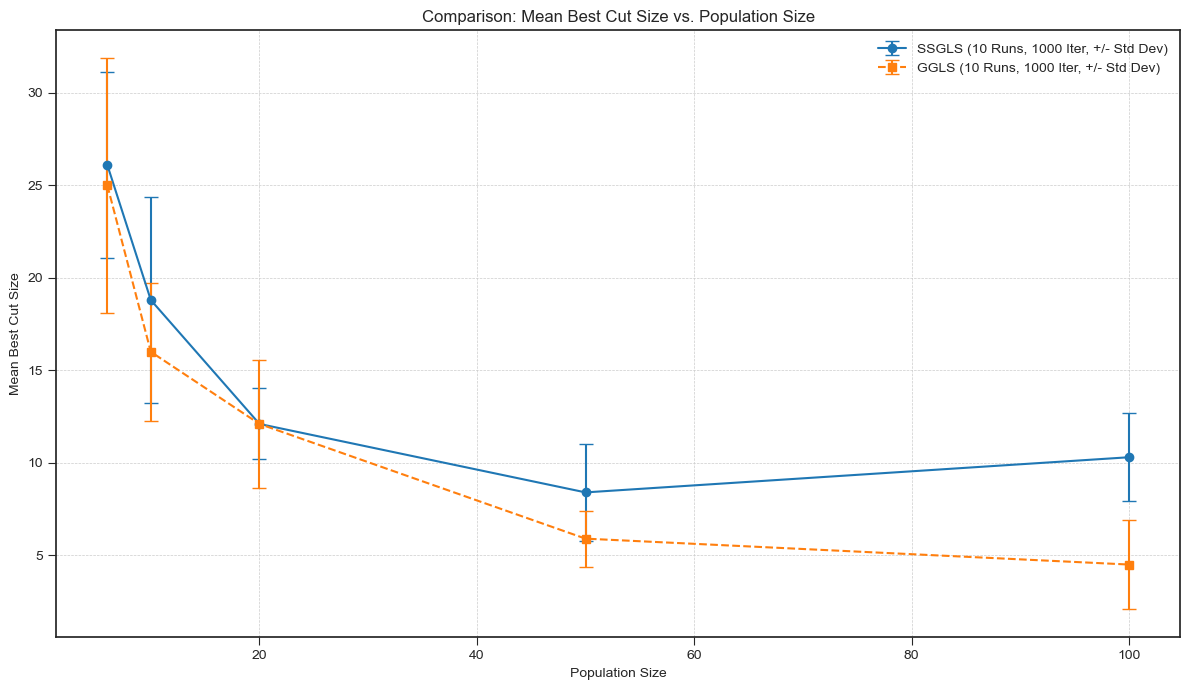

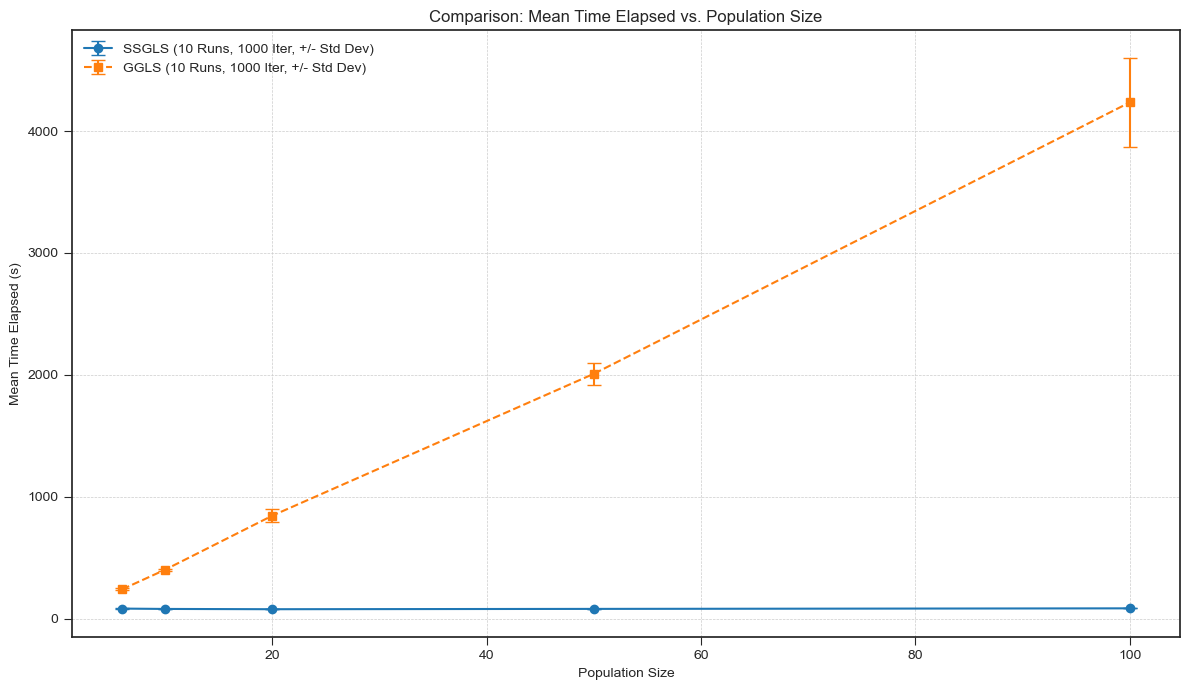

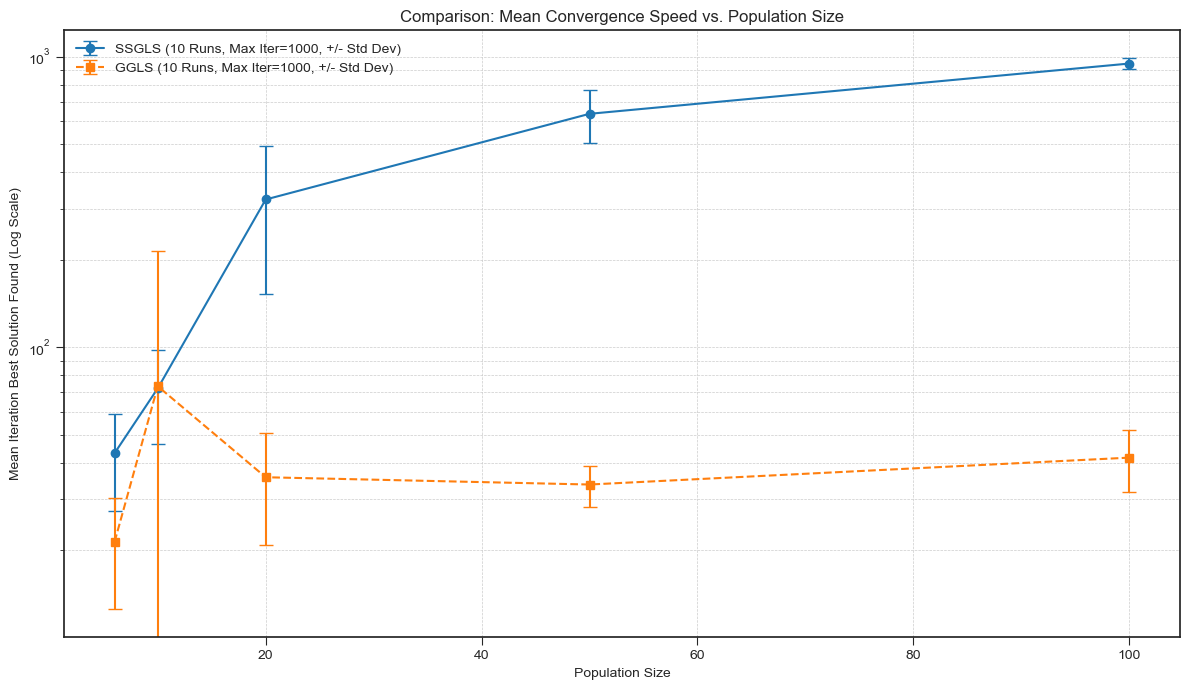


Plotting combined convergence curves for common pop sizes: [6, 10, 20, 50, 100]


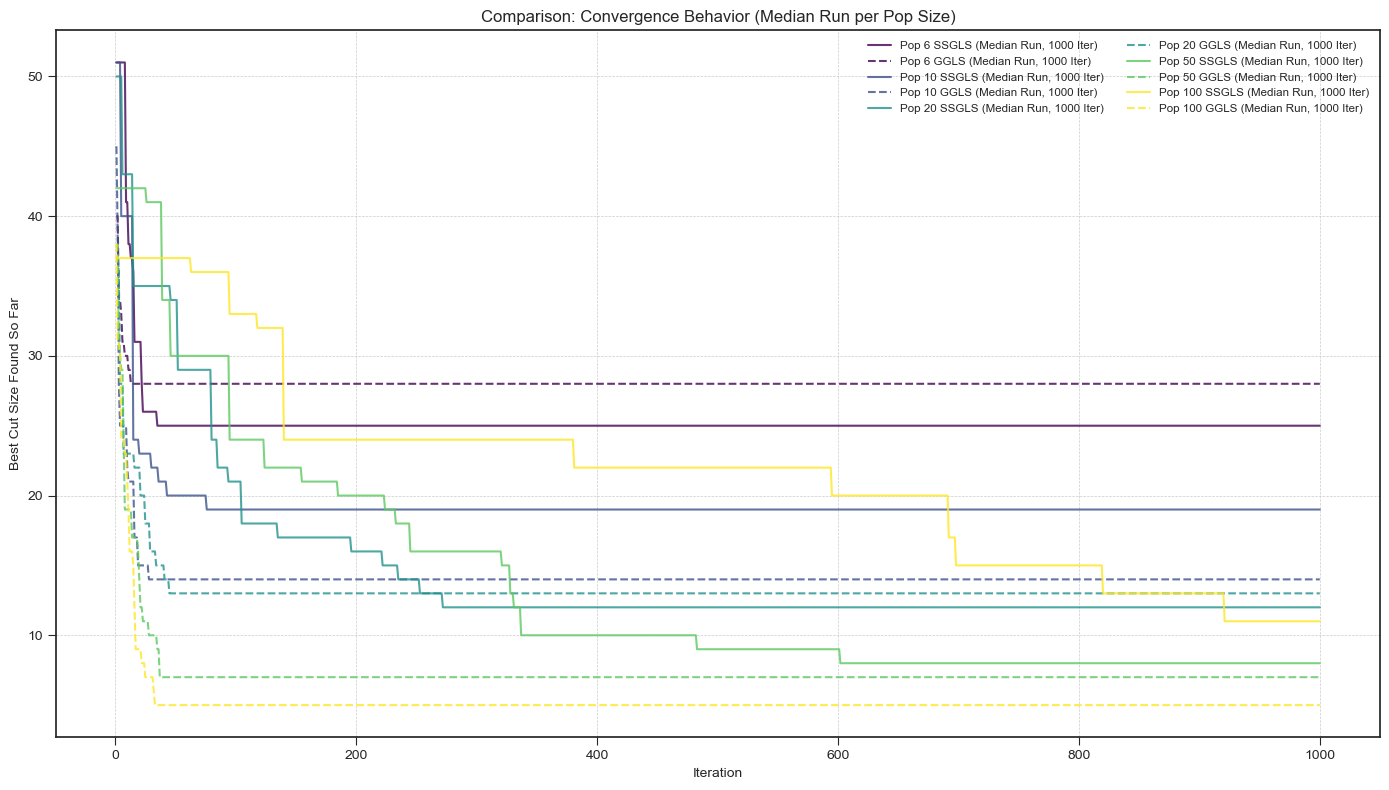

In [9]:
plt.style.use('seaborn-v0_8-ticks' ) 
# titles parts 
ssgls_runs = df_ssgls_agg["num_runs"].iloc[0]
ssgls_iters = int(df_ssgls_agg["max_iterations"].iloc[0]) 
ggls_runs = df_ggls_agg["num_runs"].iloc[0]
ggls_iters = int(df_ggls_agg["max_iterations"].iloc[0]) 

# Plot 1 Best Cut Size Comparison 
plt.figure(figsize=(12, 7))
plt.errorbar(df_ssgls_agg["pop_size"], df_ssgls_agg["mean_best_cut_size"], yerr=df_ssgls_agg["std_dev_best_cut_size"],
                marker='o', capsize=5, linestyle='-', label=f'SSGLS ({ssgls_runs} Runs, {ssgls_iters} Iter, +/- Std Dev)')
plt.errorbar(df_ggls_agg["pop_size"], df_ggls_agg["mean_best_cut_size"], yerr=df_ggls_agg["std_dev_best_cut_size"],
                marker='s', capsize=5, linestyle='--', label=f'GGLS ({ggls_runs} Runs, {ggls_iters} Iter, +/- Std Dev)')
plt.xlabel("Population Size")
plt.ylabel("Mean Best Cut Size")
plt.title("Comparison: Mean Best Cut Size vs. Population Size")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 2 Time Elapsed Comparison
plt.figure(figsize=(12, 7))
plt.errorbar(df_ssgls_agg["pop_size"], df_ssgls_agg["mean_time_elapsed"], yerr=df_ssgls_agg["std_dev_time_elapsed"],
                marker='o', capsize=5, linestyle='-', label=f'SSGLS ({ssgls_runs} Runs, {ssgls_iters} Iter, +/- Std Dev)')
plt.errorbar(df_ggls_agg["pop_size"], df_ggls_agg["mean_time_elapsed"], yerr=df_ggls_agg["std_dev_time_elapsed"],
                marker='s', capsize=5, linestyle='--', label=f'GGLS ({ggls_runs} Runs, {ggls_iters} Iter, +/- Std Dev)')
plt.xlabel("Population Size")
plt.ylabel("Mean Time Elapsed (s)")
plt.title("Comparison: Mean Time Elapsed vs. Population Size")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 3 Convergence Speed Comparison 
plt.figure(figsize=(12, 7))
plt.errorbar(df_ssgls_agg["pop_size"], df_ssgls_agg["mean_convergence_iteration"], yerr=df_ssgls_agg["std_dev_convergence_iteration"],
                marker='o', capsize=5, linestyle='-', label=f'SSGLS ({ssgls_runs} Runs, Max Iter={ssgls_iters}, +/- Std Dev)')
plt.errorbar(df_ggls_agg["pop_size"], df_ggls_agg["mean_convergence_iteration"], yerr=df_ggls_agg["std_dev_convergence_iteration"],
                marker='s', capsize=5, linestyle='--', label=f'GGLS ({ggls_runs} Runs, Max Iter={ggls_iters}, +/- Std Dev)')
plt.xlabel("Population Size")
plt.ylabel("Mean Iteration Best Solution Found (Log Scale)")
plt.title("Comparison: Mean Convergence Speed vs. Population Size")
plt.yscale('log') 
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 4 Convergence Behavior Comparison (Median Runs) ---
plt.figure(figsize=(14, 8))
plot_success_p4c = False
common_pop_sizes_logs = sorted(list(set(ssgls_convergence_logs.keys()) & set(ggls_convergence_logs.keys())))


print(f"\nPlotting combined convergence curves for common pop sizes: {common_pop_sizes_logs}")
colors = plt.cm.viridis(np.linspace(0, 1, len(common_pop_sizes_logs))) 

for i, pop_size_key in enumerate(common_pop_sizes_logs):
    color = colors[i]
    label_prefix = f'Pop {pop_size_key}'
    
    iter_df_ssgls = ssgls_convergence_logs.get(pop_size_key)
    if iter_df_ssgls is not None and not iter_df_ssgls.empty and 'best_cut_size_so_far' in iter_df_ssgls.columns:
        plt.plot(iter_df_ssgls.index, iter_df_ssgls['best_cut_size_so_far'],
                    label=f'{label_prefix} SSGLS (Median Run, {ssgls_iters} Iter)', alpha=0.8, color=color, linestyle='-')
        plot_success_p4c = True

    iter_df_ggls = ggls_convergence_logs.get(pop_size_key)
    if iter_df_ggls is not None and not iter_df_ggls.empty and 'best_cut_size_so_far' in iter_df_ggls.columns:
            plt.plot(iter_df_ggls.index, iter_df_ggls['best_cut_size_so_far'],
                    label=f'{label_prefix} GGLS (Median Run, {ggls_iters} Iter)', alpha=0.8, color=color, linestyle='--')
            plot_success_p4c = True

plt.xlabel("Iteration") 
plt.ylabel("Best Cut Size Found So Far") 
plt.title("Comparison: Convergence Behavior (Median Run per Pop Size)")
# plt.xscale('log') # Optional
# plt.yscale('log') # Optional
plt.legend(fontsize='small', ncol=2) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
